In [1]:
#@title Import Time Series Feature Extraction Library
import warnings
warnings.filterwarnings('ignore')
!pip install tsfel >/dev/null 2>&1
from sys import platform
if platform == "linux" or platform == "linux2":
    !wget http://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip >/dev/null 2>&1
else:
    !pip install wget >/dev/null 2>&1
    import wget
    wget.download('http://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI HAR Dataset.zip')

In [2]:
# Import libraries
import tsfel
import glob
import zipfile

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
sns.set()

# Unzip dataset
zip_ref = zipfile.ZipFile("UCI HAR Dataset.zip", 'r')
zip_ref.extractall()
zip_ref.close()

In [3]:
#@title Data Preparation

# Load data
x_train_sig = list(np.loadtxt('UCI HAR Dataset/train/Inertial Signals/total_acc_x_train.txt', dtype='float32'))
x_test_sig = list(np.loadtxt('UCI HAR Dataset/test/Inertial Signals/total_acc_x_test.txt', dtype='float32'))
y_test = np.loadtxt('UCI HAR Dataset/test/y_test.txt')
y_train = np.loadtxt('UCI HAR Dataset/train/y_train.txt')
activity_labels = np.array(pd.read_csv('UCI HAR Dataset/activity_labels.txt', header=None, delimiter=' '))[:,1]

# dataset sampling frequency
fs = 100

In [4]:
print(type(x_train_sig))

<class 'list'>


In [5]:
print("Total samples in train data:", len(x_train_sig))
print("Shape of each train sample:", x_train_sig[0].shape)

Total samples in train data: 7352
Shape of each train sample: (128,)


# TSFEL

In [7]:
cfg_file = tsfel.get_features_by_domain('statistical') # Only statistical features

# Get features
X_train = tsfel.time_series_features_extractor(cfg_file, x_train_sig, fs=fs)
X_test = tsfel.time_series_features_extractor(cfg_file, x_test_sig, fs=fs)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***


In [8]:
X_train.shape

(7352, 40)

In [9]:
# Highly correlated features are removed
corr_features = tsfel.correlated_features(X_train)
X_train.drop(corr_features, axis=1, inplace=True)
X_test.drop(corr_features, axis=1, inplace=True)

# Remove low variance features
selector = VarianceThreshold()
X_train = selector.fit_transform(X_train)
X_test = selector.transform(X_test)

# Normalising Features
scaler = preprocessing.StandardScaler()
nX_train = scaler.fit_transform(X_train)
nX_test = scaler.transform(X_test)

In [10]:
classifier = DecisionTreeClassifier()
# Train the classifier
classifier.fit(nX_train, y_train.ravel())

# Predict test data
y_test_predict = classifier.predict(nX_test)

# Get the classification report
accuracy = accuracy_score(y_test, y_test_predict) * 100
print(classification_report(y_test, y_test_predict, target_names=activity_labels))
print("Accuracy: " + str(accuracy) + '%')

                    precision    recall  f1-score   support

           WALKING       0.64      0.69      0.67       496
  WALKING_UPSTAIRS       0.63      0.61      0.62       471
WALKING_DOWNSTAIRS       0.75      0.71      0.73       420
           SITTING       0.54      0.58      0.56       491
          STANDING       0.58      0.55      0.57       532
            LAYING       1.00      1.00      1.00       537

          accuracy                           0.69      2947
         macro avg       0.69      0.69      0.69      2947
      weighted avg       0.69      0.69      0.69      2947

Accuracy: 69.22293858160842%


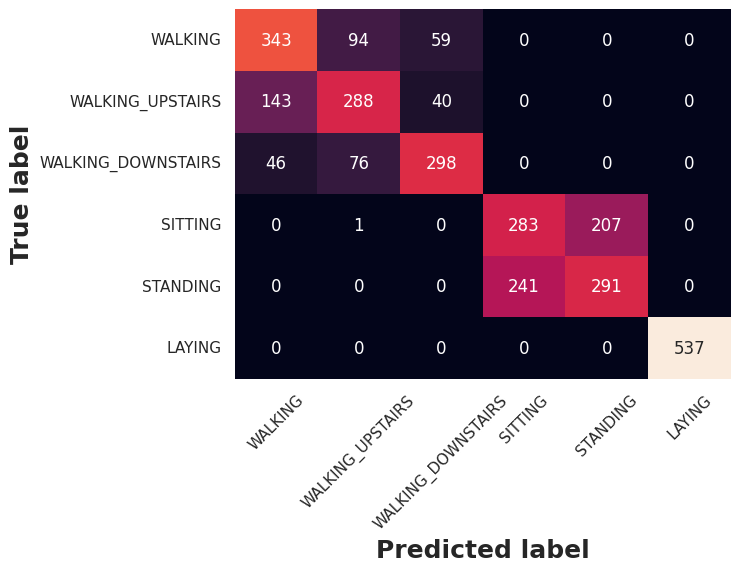

In [11]:
cm = confusion_matrix(y_test, y_test_predict)
df_cm = pd.DataFrame(cm, index=[i for i in activity_labels], columns=[i for i in activity_labels])
plt.figure()
ax= sns.heatmap(df_cm,  cbar=False, annot=True, fmt="d")
plt.setp(ax.get_xticklabels(), rotation=45)

plt.ylabel('True label', fontweight='bold', fontsize = 18)
plt.xlabel('Predicted label', fontweight='bold', fontsize = 18)
bottom, top = ax.get_ylim()
plt.show()

In [12]:
classification_reports2 = {}
acc_values2 = []
depths = [i for i in range(2, 9)]
for depth in depths:
  classifier = DecisionTreeClassifier(max_depth = depth)
  classifier.fit(nX_train, y_train.ravel())
  y_test_predict = classifier.predict(nX_test)

  accuracy = accuracy_score(y_test, y_test_predict)
  acc_values2.append(accuracy)
  classification_reports2[depth] = classification_report(y_test, y_test_predict, target_names=activity_labels)
  print("Accuracy: ", accuracy)

Accuracy:  0.5310485239226331
Accuracy:  0.6474380726162199
Accuracy:  0.6939260264675942
Accuracy:  0.7353240583644384
Accuracy:  0.7472005429250085
Accuracy:  0.7309127926705123
Accuracy:  0.7431286053613845


# PCA

In [14]:
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_train)
print(principal_components.shape)

(7352, 2)


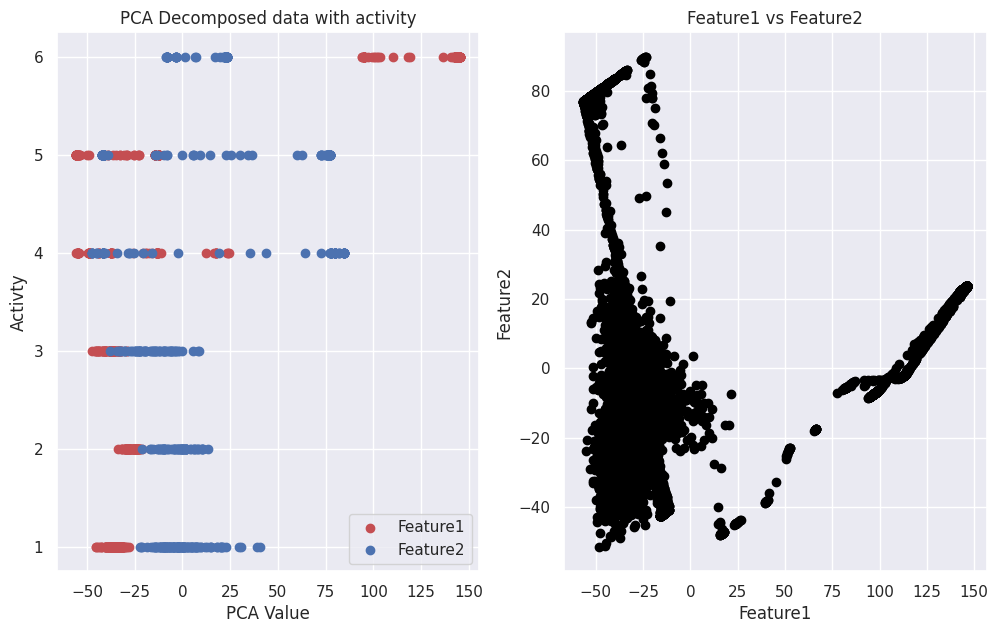

In [15]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.scatter(principal_components[:500, 0], y_train[:500], c='r')
plt.scatter(principal_components[:500, 1], y_train[:500], c='b')
plt.legend(["Feature1", "Feature2"])
plt.ylabel("Activty"), plt.xlabel("PCA Value"), plt.title("PCA Decomposed data with activity")

plt.subplot(1, 2, 2)
plt.scatter(principal_components[:, 0], principal_components[:, 1], c='black')
plt.xlabel("Feature1"), plt.ylabel("Feature2"), plt.title("Feature1 vs Feature2")
plt.show()

In [16]:
tree2 = DecisionTreeClassifier()
tree2.fit(X_train, y_train)
predictions = tree2.predict(X_test)
print("Accuracy after PCA of x:", accuracy_score(predictions, y_test))

Accuracy after PCA of x: 0.6979979640312182


In [17]:
classification_reports1 = {}
acc_values1 = []
depths = [i for i in range(2, 9)]
for depth in depths:
    tree = DecisionTreeClassifier(max_depth=depth)
    tree.fit(X_train, y_train)
    predictions = tree.predict(X_test)
    acc_score = accuracy_score(predictions, y_test)
    print("Accuracy:", acc_score)
    acc_values1.append(acc_score)
    classification_reports1[depth] = classification_report(y_test, predictions, target_names=activity_labels)

Accuracy: 0.5310485239226331
Accuracy: 0.6474380726162199
Accuracy: 0.6939260264675942
Accuracy: 0.7353240583644384
Accuracy: 0.7465218866644044
Accuracy: 0.7309127926705123
Accuracy: 0.7451645741431965


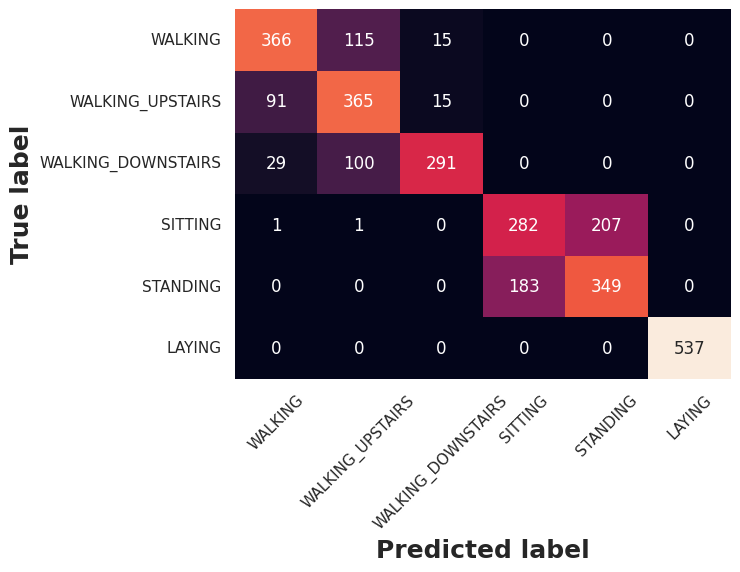

In [18]:
cm = confusion_matrix(y_test, y_test_predict)
df_cm = pd.DataFrame(cm, index=[i for i in activity_labels], columns=[i for i in activity_labels])
plt.figure()
ax= sns.heatmap(df_cm,  cbar=False, annot=True, fmt="d")
plt.setp(ax.get_xticklabels(), rotation=45)

plt.ylabel('True label', fontweight='bold', fontsize = 18)
plt.xlabel('Predicted label', fontweight='bold', fontsize = 18)
bottom, top = ax.get_ylim()
plt.show()

# Classification

In this example the classification is performed with a [Random Forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) classifier.

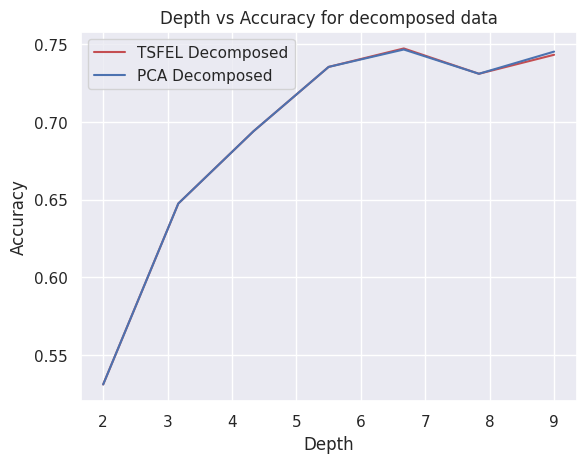

In [19]:
plt.plot(np.linspace(2, 9, 7), acc_values2, c = "r")
plt.plot(np.linspace(2, 9, 7), acc_values1, c = "b")
plt.xlabel("Depth"), plt.ylabel("Accuracy"), plt.title('Depth vs Accuracy for decomposed data')
plt.legend(["TSFEL Decomposed", "PCA Decomposed"])
plt.show()

# Conclusion

As it can be seen in the confusion matrix, the misclassification was higher between WALKING UPSTAIRS vs WALKING DOWNSTAIRS vs WALKING and SITTING vs STANDING. Dynamic activities, due to their distinct motion characteristics and cyclic behaviour, were clearly discriminated against static activities.
Also, accuracies for PCA decomposed data and TSFEL decomposed data are nearly the same.